### Import Libraries

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns

### Load Dataset

In [5]:
# Path to the main folders
training_path = "/kaggle/input/hand-gestures-recognition/dataset/training_set"
testing_path = "/kaggle/input/hand-gestures-recognition/dataset/test_set"

In [6]:
# Subfolders and their labels for training dataset
subfolders_train = ['L','four', 'three', 'thumbsup','two','up']
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders_train)}

# Prepare lists to hold images and labels
images = []
labels = []

# Load images and labels
for subfolder in subfolders_train:
    subfolder_path = os.path.join(training_path, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (224, 224))  # Resize to 224x224
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Convert to NumPy arrays
x_train = np.array(images)
y_train = np.array(labels)

# Normalize the images
x_train = x_train.astype('float32') / 255.0

In [7]:
# Subfolders and their labels for testing dataset
subfolders_test = ['L','four', 'three', 'thumbsup','two','up']
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders_test)}

# Prepare lists to hold images and labels
images = []
labels = []

# Load images and labels
for subfolder in subfolders_test:
    subfolder_path = os.path.join(testing_path, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (224, 224))  # Resize to 224x224
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Convert to NumPy arrays
x_test = np.array(images)
y_test = np.array(labels)

# Normalize the images
x_test = x_test.astype('float32') / 255.0

In [8]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(8459, 224, 224, 3) (8459,)
(3460, 224, 224, 3) (3460,)


### Visualization

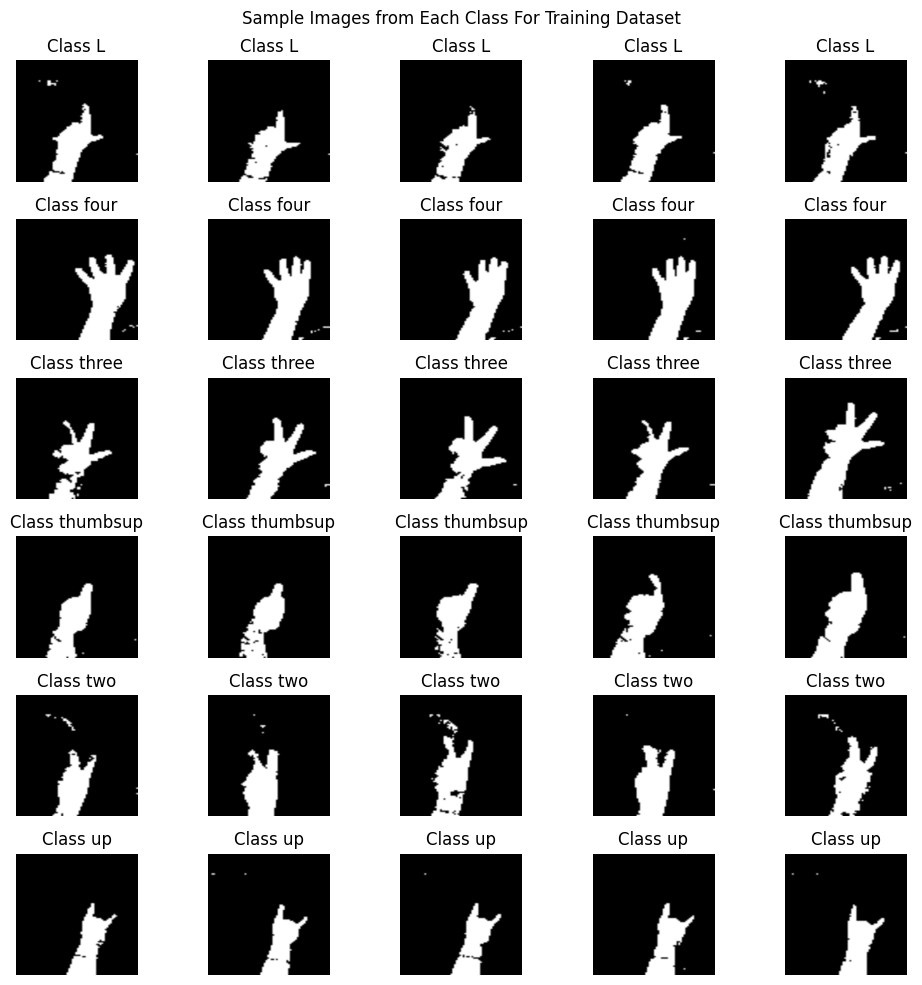

In [9]:
# Plot 5 images for each class for training dataset
plt.figure(figsize=(10, 10))
for i, subfolder in enumerate(subfolders_train):
    class_indices = np.where(y_train == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders_train), 5, i * 5 + j + 1)
        plt.imshow(x_train[class_indices[j]])
        plt.title(f'Class {subfolder}')
        plt.axis('off')
plt.suptitle('Sample Images from Each Class For Training Dataset')
plt.tight_layout()
plt.show()

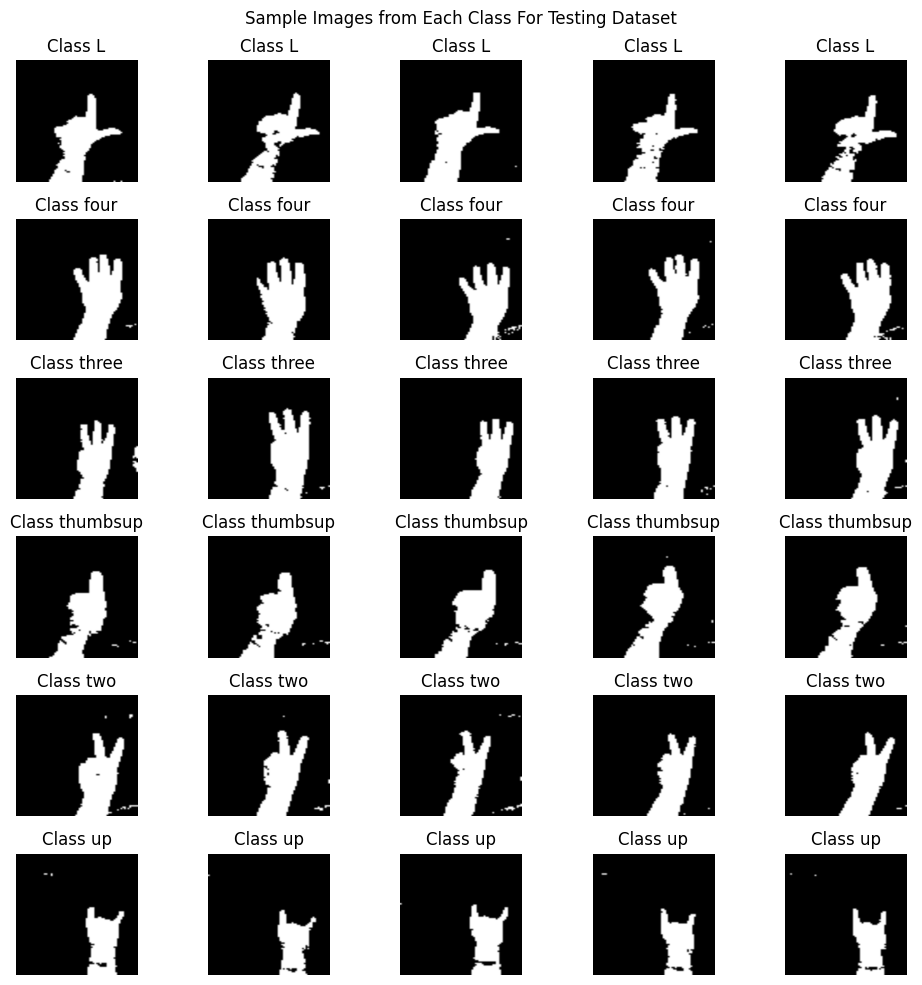

In [10]:
# Plot 5 images for each class for testing dataset
plt.figure(figsize=(10, 10))
for i, subfolder in enumerate(subfolders_test):
    class_indices = np.where(y_test == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders_test), 5, i * 5 + j + 1)
        plt.imshow(x_test[class_indices[j]])
        plt.title(f'Class {subfolder}')
        plt.axis('off')
plt.suptitle('Sample Images from Each Class For Testing Dataset')
plt.tight_layout()
plt.show()

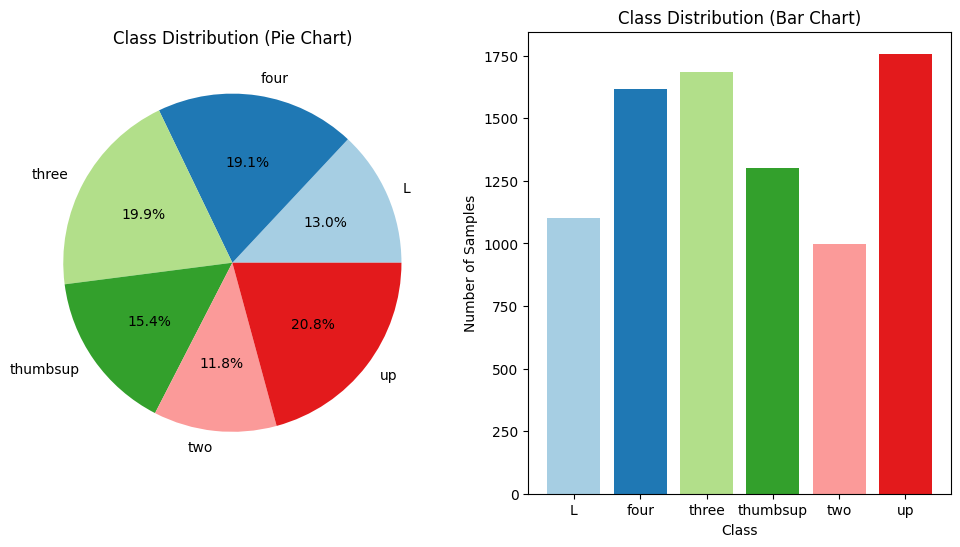

In [11]:
# Plot class distribution as a pie and bar chart
class_counts = np.bincount(y_train)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(class_counts, labels=subfolders_train, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Class Distribution (Pie Chart)')

plt.subplot(1, 2, 2)
plt.bar(subfolders_train, class_counts, color=plt.cm.Paired.colors)
plt.title('Class Distribution (Bar Chart)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.show()

In [12]:
# One-hot encode the labels
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=len(subfolders_train))
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=len(subfolders_test))

print(x_train.shape, y_train_encoded.shape)
print(x_test.shape, y_test_encoded.shape) 

(8459, 224, 224, 3) (8459, 6)
(3460, 224, 224, 3) (3460, 6)


### Building Model

In [13]:
# Build the CNN model with Dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after first pooling layer

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after second pooling layer

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after third pooling layer

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),  # Add Dropout before final dense layer

    tf.keras.layers.Dense(len(subfolders_train), activation='softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       692,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 706,790 (2.70 MB)

 Trainable params: 706,790 (2.70 MB)

 Non-trainable params: 0 (0.00 B)

None


### Training

In [16]:
# Train the model
model.fit(x_train, y_train_encoded, epochs=3,batch_size=128)

Epoch 1/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.8302 - loss: 0.4819
Epoch 2/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.9993 - loss: 0.0039
Epoch 3/3
67/67 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.9995 - loss: 0.0016


### Evaluate Model 

In [23]:
# Evaluate the model 
loss, acc = model.evaluate(x_train, y_train_encoded)
print(f'Accuracy: {acc}')
print(f'Loss: {loss}')

265/265 ━━━━━━━━━━━━━━━━━━━━ 62s 233ms/step - accuracy: 0.9988 - loss: 0.0032
Accuracy: 0.9994089007377625
Loss: 0.0036716635804623365


In [24]:
# Classification report
y_pred = np.argmax(model.predict(x_train), axis=1)
y_true = np.argmax(y_train_encoded, axis=1)
print(classification_report(y_true, y_pred, target_names=subfolders_train))

265/265 ━━━━━━━━━━━━━━━━━━━━ 75s 284ms/step
              precision    recall  f1-score   support

           L       1.00      1.00      1.00      1102
        four       1.00      1.00      1.00      1617
       three       1.00      1.00      1.00      1683
    thumbsup       1.00      1.00      1.00      1303
         two       1.00      1.00      1.00       996
          up       1.00      1.00      1.00      1758

    accuracy                           1.00      8459
   macro avg       1.00      1.00      1.00      8459
weighted avg       1.00      1.00      1.00      8459



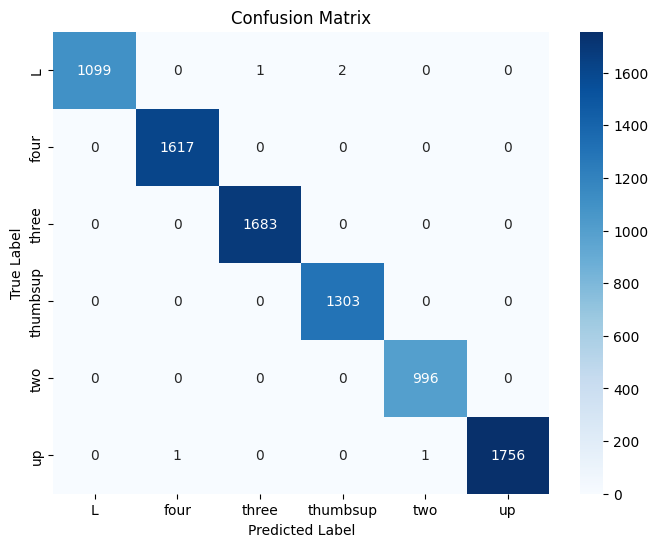

In [25]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders_train, yticklabels=subfolders_train)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Model Testing 

In [27]:
# Function to predict and display results for multiple images
def predict_and_display_results(model, images, true_labels, subfolders, num_images=4):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_images):
        # Select a random image from the test set
        index = np.random.randint(0, len(images))
        sample_image = images[index]
        true_label = np.argmax(true_labels[index])

        # Predict the probabilities for the selected image
        predictions = model.predict(np.expand_dims(sample_image, axis=0))
        predicted_label = np.argmax(predictions[0])

        # Format and print the probabilities with their corresponding labels
        formatted_probabilities = [f'Label {subfolders[i]}: {prob:.4f}' for i, prob in enumerate(predictions[0])]

        # Print the true label, predicted label, and all probabilities
        print(f'Image {i+1}:')
        print(f'True label: {subfolders[true_label]}')
        print(f'Predicted label: {subfolders[predicted_label]}')
        print('Probabilities for each class:')
        for label_prob in formatted_probabilities:
            print(label_prob)
        print()

        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(sample_image)
        plt.title(f'True: {subfolders[true_label]}\nPredicted: {subfolders[predicted_label]}')
        plt.axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image 1:
True label: up
Predicted label: up
Probabilities for each class:
Label L: 0.0015
Label four: 0.0348
Label three: 0.0000
Label thumbsup: 0.0000
Label two: 0.0258
Label up: 0.9380



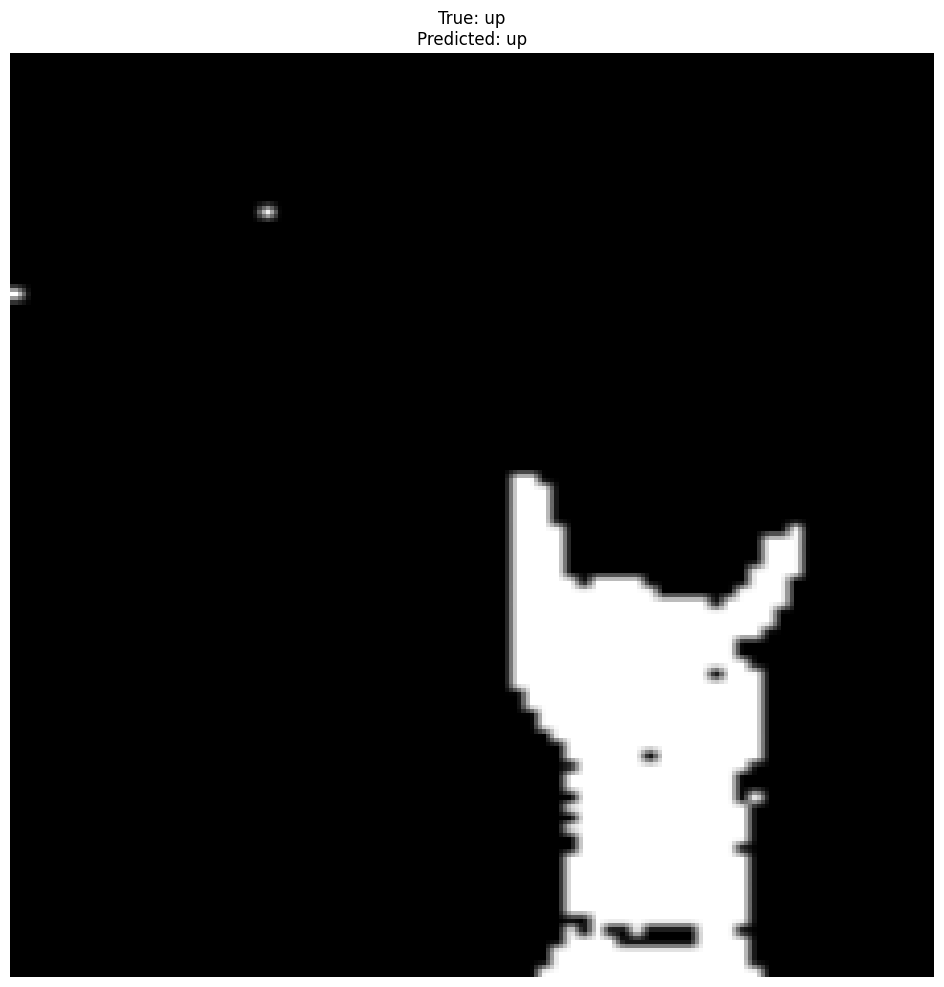

In [32]:
# Test the function with 1 images
predict_and_display_results(model, x_test, y_test_encoded, subfolders_test, num_images=1)